In [51]:
%matplotlib notebook

import numpy as np
from skimage import io
from skimage.color import rgb2lab, lab2rgb, rgb2hsv
from matplotlib import pyplot as plt

In [52]:
img = io.imread("18.jpg")

In [106]:
def transfer_color_with_metric(lab_t, mean_s, std_s):
    
    h, w = lab_t.shape[0], lab_t.shape[1]
    
    lab_t = lab_t.reshape(-1, 3)
    
    mean_t = np.mean(lab_t, axis=0)
    std_t = np.std(lab_t, axis=0)
    
    lab = (std_s/std_t)*(lab_t - mean_t) + mean_s
    
    return lab.reshape(h, w, 3)

In [84]:
def transfer_color_profile(lab_s, lab_t):
    
    h, w = lab_t.shape[0], lab_t.shape[1]
    
    lab_s = lab_s[:600, :, :].reshape(-1, 3)
    
    mean_s = np.mean(lab_s, axis=0)
    std_s = np.std(lab_s, axis=0)
    
    #lab = (std_s/std_t)*(lab_t - mean_t) + mean_s
    
    mean_s = np.array([ 63.94263681,  -2.27450881, -28.46108085])
    std_s = np.clip(np.array([6.90647539e-10, 3.18451931e-11, 2.18690843e-10]), 7, None)
    
    return transfer_color_with_metric(lab_t, mean_s, std_s)
    
    """
    
    lab_s = lab_s.reshape(-1, 3)
    lab_t = lab_t.reshape(-1, 3)
    
    mean_s = np.mean(lab_s, axis=0)
    std_s = np.std(lab_s, axis=0)

    mean_t = np.mean(lab_t, axis=0)
    std_t = np.std(lab_t, axis=0)
    
    lab = (std_s/std_t)*(lab_t - mean_t) + mean_s
    
    return lab.reshape(h, w, 3)
    """

In [85]:
target = io.imread("d2.jpg")

target_lab = rgb2lab(target/255.)
lab = rgb2lab(img/255.)

tx_lab = transfer_color_profile(lab, target_lab)

tx_rgb = lab2rgb(tx_lab)

[53.48326976  9.55842812  9.97987328]
[24.99968696 16.58654007 36.357428  ]
[ 63.94263681  -2.27450881 -28.46108085]
[7. 7. 7.]


<IPython.core.display.Javascript object>


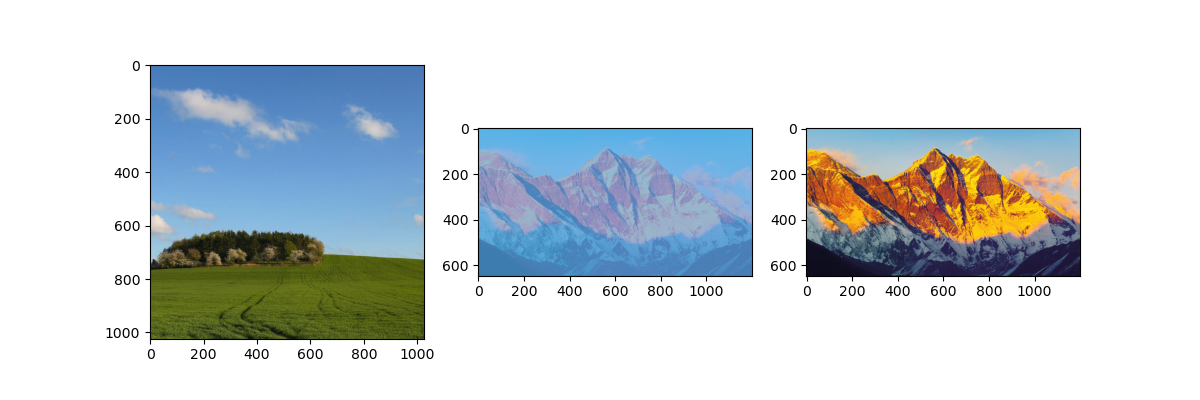

In [86]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
bx = fig.add_subplot(132)
cx = fig.add_subplot(133)

ax.imshow(img, vmin=0, vmax=1)
bx.imshow(tx_rgb, vmin=0, vmax=1)
cx.imshow(target, vmin=0, vmax=1)

plt.show()

In [6]:
import scipy.cluster.vq as scivq

In [7]:
codes, dists = scivq.kmeans(lab.reshape(-1, 3), 2)

In [8]:
print(codes)

[[ 63.94263681  -2.27450881 -28.46108085]
 [ 35.84058895 -13.16223449  33.59719509]]


In [9]:
vecs, dists = scivq.vq(lab.reshape(-1, 3), codes)

In [10]:
print(vecs.shape)
print(dists.shape)

(1048576,)
(1048576,)


In [11]:
vecs = vecs.reshape(lab.shape[0], lab.shape[1])

In [12]:
print(vecs.shape)

(1024, 1024)


In [13]:
lab_new = np.zeros_like(lab)
lab_new = codes[vecs]

rgb_new = lab2rgb(lab_new)

In [14]:
codes[vecs].shape

(1024, 1024, 3)

<IPython.core.display.Javascript object>


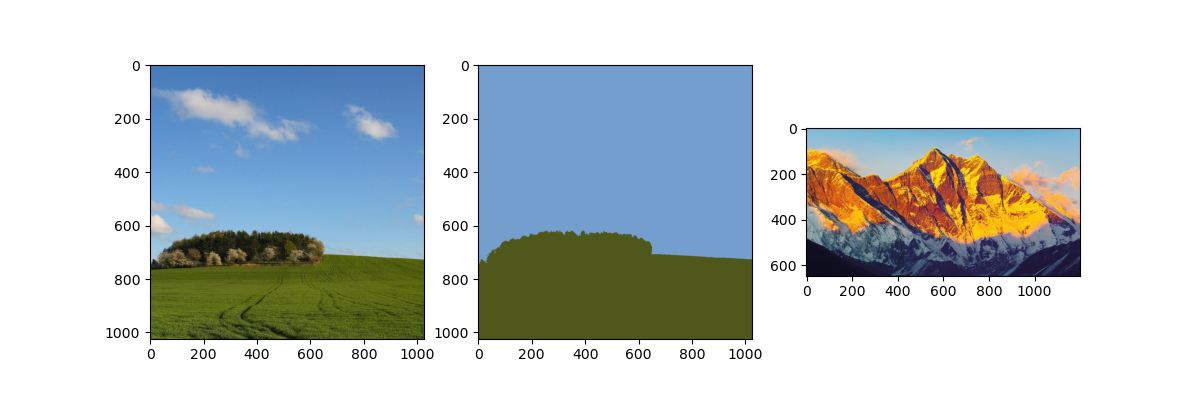

In [16]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
bx = fig.add_subplot(132)
cx = fig.add_subplot(133)

ax.imshow(img, vmin=0, vmax=1)
bx.imshow(rgb_new, vmin=0, vmax=1)
cx.imshow(target, vmin=0, vmax=1)

plt.show()

In [15]:
first_swatch = np.argwhere(vecs == 0)
second_swatch = np.argwhere(vecs == 1)

In [18]:
print(first_swatch.shape)
print(second_swatch.shape)

swatches = [first_swatch, second_swatch]

(686801, 2)
(361775, 2)


In [77]:
swatch_means = []
swatch_stds = []
swatch_segments = []

for i in range(len(swatches)):

    current_values = []
    swatch_img = np.zeros((lab_new.shape[0], lab_new.shape[1], 3))
    
    for u, v in swatches[i]:
        current_values.append(lab_new[u, v, :])
        swatch_img[u, v, :] = lab_new[u, v, :]
    
    swatch_segments.append(swatch_img)
    
    current_values = np.vstack(current_values)
    swatch_means.append(np.mean(current_values, axis=0))
    swatch_stds.append(np.std(current_values, axis=0))

In [65]:
mean_img1 = np.tile(swatch_means[0], 256*256).reshape(256, 256, 3)
mean_img2 = np.tile(swatch_means[1], 256*256).reshape(256, 256, 3)

In [76]:
print(swatch_img[0].shape)

(1024, 3)


<IPython.core.display.Javascript object>


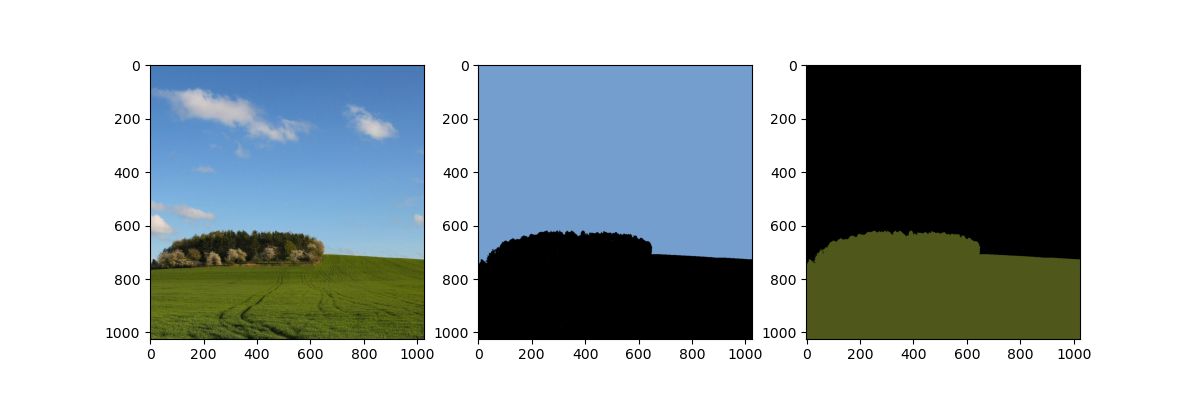

In [78]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
bx = fig.add_subplot(132)
cx = fig.add_subplot(133)

ax.imshow(img, vmin=0, vmax=1)
bx.imshow(lab2rgb(swatch_segments[0]), vmin=0, vmax=1)
cx.imshow(lab2rgb(swatch_segments[1]), vmin=0, vmax=1)

plt.show()

In [125]:
lab_imgs = []
img_dists = []

h, w = target_lab.shape[0], target_lab.shape[1]

lab_shifted_merged = np.zeros((h, w, 3))

for i in range(len(swatches)):
    print(target_lab.reshape(-1, 3).shape)
    print((np.sqrt((target_lab.reshape(-1, 3) - swatch_means[i])**2)/swatch_stds[i]).shape)
    lab_img_dist = np.sqrt((target_lab.reshape(-1, 3) - swatch_means[i])**2) / swatch_stds[i]
    #lab_img_dist = (lab_img_dist - np.min(lab_img_dist, axis=0))/(np.max(lab_img_dist, axis=0)-np.min(lab_img_dist, axis=0))
    #lab_img_dist += 1e-3
    #lab_img_dist = np.clip(lab_img_dist, 1e-2, None)
    lab_img_dist = lab_img_dist.reshape(h, w, 3)
    img_dists.append(lab_img_dist)
    
    lab_shifted = transfer_color_with_metric(target_lab, swatch_means[i], np.clip(swatch_stds[i], 7, None))
    lab_imgs.append(lab_shifted)
    lab_shifted_merged += np.multiply((1./lab_img_dist),lab_shifted)
    print(np.min(lab_shifted_merged.reshape(-1, 3), axis=0))
    print(np.max(lab_shifted_merged.reshape(-1, 3), axis=0))
    
lab_shifted_merged = lab_shifted_merged.reshape(-1, 3)
lab_shifted_merged = (lab_shifted_merged - np.min(lab_shifted_merged, axis=0))/(np.max(lab_shifted_merged, axis=0) - np.min(lab_shifted_merged, axis=0))
lab_shifted_merged = lab_shifted_merged.reshape(h, w, 3)

lab_shifted_merged[:, :, :1] *= 100
lab_shifted_merged[:, :, 1:] = lab_shifted_merged[:, :, 1:]*254.0 - 127.0

print(np.min(target_lab.reshape(-1, 3), axis=0))
print(np.max(target_lab.reshape(-1, 3), axis=0))
print(np.min(lab_shifted_merged.reshape(-1, 3), axis=0))
print(np.max(lab_shifted_merged.reshape(-1, 3), axis=0))
#lab_new_s1 = np.linalg.norm(lab_new - swatch1_mean, axis=2) / swatch1_std

(774000, 3)
(774000, 3)
[ 5.54420528e-10 -5.48686821e-06 -5.52897637e-06]
[ 3.34306407e-03  1.01573125e-11 -2.25316637e-11]
(774000, 3)
(774000, 3)
[ 7.41524038e-10 -5.48687249e-06 -5.52886530e-06]
[3.34306448e-03 1.05227198e-11 5.59397229e-05]
[  2.18249629 -26.84844456 -54.80045069]
[95.01215966 68.24414894 92.87438276]
[   0. -127. -127.]
[100. 127. 127.]


<IPython.core.display.Javascript object>


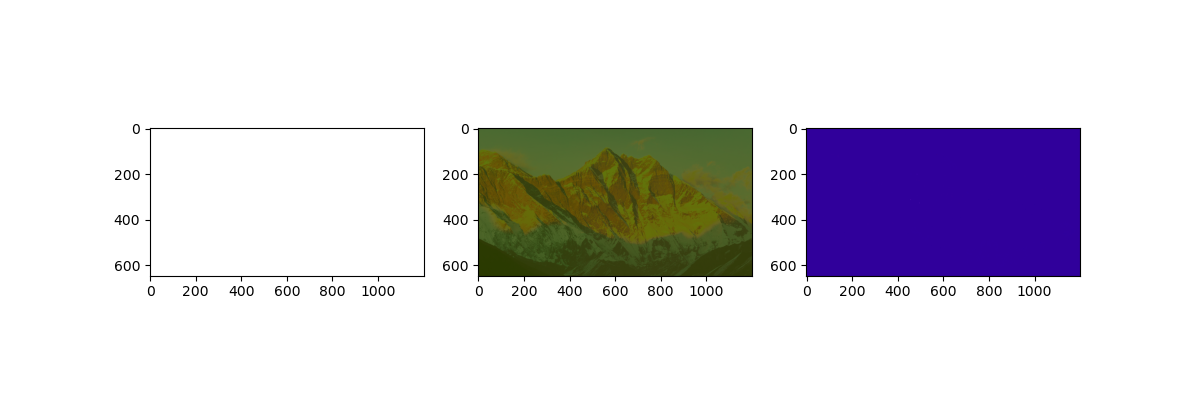

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/saad/anaconda3/envs/py39/lib/python3.9/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


In [126]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131)
bx = fig.add_subplot(132)
cx = fig.add_subplot(133)

ax.imshow(img_dists[0].reshape(h, w, 3), vmin=0, vmax=1)
bx.imshow(lab2rgb(lab_imgs[1]), vmin=0, vmax=1)
cx.imshow(lab2rgb(lab_shifted_merged), vmin=0, vmax=1)

plt.show()